# Regime-Switching Trading Strategy

**Strategy:** VIX-Based Regime Switching (Trend-Following + Mean-Reversion)  
**Universe:** Top 10 Tech Stocks  
**Benchmark:** SPY  
**Period:** 2010-2019 (with train/test split)  
**Initial Capital:** $500,000 USD  
**Transaction Cost:** 0%  
**Leverage:** 0x  

**Strategy Logic:**

### Regime 1: "Calm" (Low Volatility) - log(VIX) < 20
- **Strategy:** Trend-Following using EMA Crossover
- **Go Long:** EMA20 crosses above EMA50
- **Exit Long:** EMA20 crosses below EMA50

### Regime 2: "Panic" (High Volatility) - log(VIX) >= 20
- **Strategy:** Mean-Reversion using Bollinger Bands  
- **Go Long:** Price touches/crosses below Lower BB
- **Exit Long:** Price reverts to Middle BB
- **Go Short:** Price touches/crosses above Upper BB
- **Exit Short:** Price reverts to Middle BB
- **Stop Loss:** 3% from entry

### Critical Rule: Regime Switch
**All open positions are immediately closed when regime switches!**

**Enhancements:**
- Comprehensive metrics including VAR, CVAR, Beta, Alpha (vs SPY)
- Train/test split with out-of-sample validation
- Detailed visualizations and regime analysis
- Regime-specific performance breakdown

---

## 1. Setup and Imports

In [1]:
# Install required packages
%pip install pandas numpy yfinance matplotlib seaborn ta scipy tqdm -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, ADXIndicator
from ta.volatility import AverageTrueRange
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
from scipy.interpolate import griddata
import json

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ All imports successful!")

✅ All imports successful!


## 2. Configuration and Data Classes

In [3]:
@dataclass
class StrategyConfig:
    """RSI Retracement Strategy Configuration"""
    # Technical indicator parameters
    ema_fast: int = 20
    ema_slow: int = 50
    rsi_period: int = 14
    
    # RSI retracement parameters (optimizable)
    rsi_high_threshold: float = 70.0
    rsi_low_threshold: float = 30.0
    rsi_retrace_upper: float = 40.0  # Upper bound for buy retracement
    rsi_retrace_lower: float = 30.0  # Lower bound for buy retracement
    rsi_retrace_short_upper: float = 70.0  # Upper bound for sell retracement
    rsi_retrace_short_lower: float = 60.0  # Lower bound for sell retracement
    lookback_window: int = 20
    rsi_avg_window: int = 5
    rsi_avg_threshold_buy: float = 40.0
    rsi_avg_threshold_sell: float = 60.0
    
    # Risk management
    stop_loss_pct: float = 0.02
    trailing_stop_pct: float = 0.015
    max_portfolio_drawdown: float = 0.15
    risk_per_trade: float = 0.02
    min_position_size: float = 0.1
    max_position_size: float = 0.2
    
    # Portfolio parameters
    initial_capital: float = 500000.0
    transaction_cost: float = 0.0
    leverage: float = 0.0
    max_positions: int = 10
    
    # Data parameters
    train_start: str = "2010-01-01"
    train_end: str = "2017-12-31"
    test_start: str = "2018-01-01"
    test_end: str = "2019-12-31"


class EventType(Enum):
    """Types of market events"""
    BUY_SIGNAL = "buy_signal"
    SELL_SIGNAL = "sell_signal"
    STOP_LOSS_HIT = "stop_loss_hit"
    TRAILING_STOP_HIT = "trailing_stop_hit"
    MAX_DRAWDOWN_HIT = "max_drawdown_hit"


@dataclass
class Event:
    """Represents a market event"""
    timestamp: datetime
    event_type: EventType
    symbol: str
    data: Dict
    priority: int = 0
    
    def __repr__(self):
        return f"Event({self.timestamp.date()}, {self.symbol}, {self.event_type.value}, priority={self.priority})"


@dataclass
class Position:
    """Represents an open position"""
    symbol: str
    side: str
    entry_price: float
    entry_time: datetime
    shares: float
    stop_loss: float
    trailing_stop: float
    highest_price: float = 0.0
    lowest_price: float = float('inf')
    
    @property
    def value(self) -> float:
        return self.shares * self.entry_price


@dataclass
class Trade:
    """Completed trade record"""
    symbol: str
    side: str
    entry_time: datetime
    exit_time: datetime
    entry_price: float
    exit_price: float
    shares: float
    pnl: float
    pnl_pct: float
    reason: str


print("✅ Configuration and data classes defined!")

✅ Configuration and data classes defined!


## 3. Get SPY Constituent Stocks

In [4]:
def get_spy_stocks(top_n: int = 50) -> List[str]:
    spy_stocks = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK.B', 'JNJ', 'JPM', 'V', 'PG', 'XOM',
        'BAC', 'MA', 'T', 'DIS', 'HD', 'INTC', 'VZ', 'PFE', 'MRK', 'CSCO',
        'KO', 'PEP', 'WFC', 'CMCSA', 'C', 'CVX', 'NFLX', 'ABT', 'ORCL', 'COST',
        'BA', 'MCD', 'IBM', 'UNH', 'PM', 'GE', 'HON', 'QCOM', 'AMGN', 'MDT',
        'UPS', 'BMY', 'SBUX', 'TXN', 'LOW', 'MMM', 'LMT', 'CAT', 'NKE', 'GS'
    ]
    return spy_stocks[:top_n]

SPY_STOCKS = get_spy_stocks(50)
print(f"✅ Using {len(SPY_STOCKS)} SPY stocks")

✅ Using 50 SPY stocks


## 4. Technical Indicators with RSI Retracement Logic

In [5]:
def calculate_indicators(df: pd.DataFrame, config: StrategyConfig) -> pd.DataFrame:
    """Calculate technical indicators and RSI retracement signals"""
    data = pd.DataFrame(index=df.index)
    data['Close'] = df['Close']
    data['High'] = df['High']
    data['Low'] = df['Low']
    data['Volume'] = df['Volume']
    
    # EMAs
    data['EMA_20'] = EMAIndicator(df['Close'], window=config.ema_fast, fillna=True).ema_indicator()
    data['EMA_50'] = EMAIndicator(df['Close'], window=config.ema_slow, fillna=True).ema_indicator()
    
    # RSI
    data['RSI'] = RSIIndicator(df['Close'], window=config.rsi_period, fillna=True).rsi()
    
    # Trend: 1 if uptrend (EMA20 > EMA50), -1 if downtrend
    data['trend'] = np.where(data['EMA_20'] > data['EMA_50'], 1, -1)
    
    # RSI conditions for BUY signal
    # Check if RSI was above 70 within lookback window
    data['RSI_high_window'] = data['RSI'].rolling(window=config.lookback_window).apply(
        lambda x: (x > config.rsi_high_threshold).any(), raw=True
    )
    
    # Check if RSI retraced to 30-40 range within lookback window
    data['RSI_retrace_window'] = data['RSI'].rolling(window=config.lookback_window).apply(
        lambda x: ((x >= config.rsi_retrace_lower) & (x <= config.rsi_retrace_upper)).any(), raw=True
    )
    
    # Average RSI over last 5 days
    data['RSI_avg_5d'] = data['RSI'].rolling(window=config.rsi_avg_window).mean()
    
    # RSI conditions for SELL signal
    # Check if RSI was below 30 within lookback window
    data['RSI_low_window'] = data['RSI'].rolling(window=config.lookback_window).apply(
        lambda x: (x < config.rsi_low_threshold).any(), raw=True
    )
    
    # Check if RSI retraced to 60-70 range within lookback window
    data['RSI_retrace_window_short'] = data['RSI'].rolling(window=config.lookback_window).apply(
        lambda x: ((x >= config.rsi_retrace_short_lower) & (x <= config.rsi_retrace_short_upper)).any(), raw=True
    )
    
    # Average RSI for sell
    data['RSI_avg_5d_short'] = data['RSI'].rolling(window=config.rsi_avg_window).mean()
    
    # Buy Signal
    data['Buy_Signal'] = np.where(
        (data['trend'] == 1) &
        (data['RSI_high_window'].shift(1) == 1) &
        (data['RSI_retrace_window'].shift(1) == 1) &
        (data['RSI_avg_5d'] > config.rsi_avg_threshold_buy),
        1, 0
    )
    
    # Sell Signal
    data['Sell_Signal'] = np.where(
        (data['trend'] == -1) &
        (data['RSI_low_window'].shift(1) == 1) &
        (data['RSI_retrace_window_short'].shift(1) == 1) &
        (data['RSI_avg_5d_short'] < config.rsi_avg_threshold_sell),
        1, 0
    )
    
    # Drop NaN rows
    max_window = max(config.ema_slow, config.lookback_window, config.rsi_period)
    data = data.iloc[max_window:]
    
    return data

print("✅ Technical indicators with RSI retracement logic defined!")

✅ Technical indicators with RSI retracement logic defined!


## 5. Event Detector for RSI Retracement Strategy

In [6]:
class EventDetector:
    """Detects RSI retracement buy/sell signals"""
    
    def __init__(self, config: StrategyConfig):
        self.config = config
        self.previous_state = {}
        
    def detect_events(self, symbol: str, current_data: pd.Series, prev_data: Optional[pd.Series]) -> List[Event]:
        """Detect buy/sell events based on RSI retracement signals"""
        events = []
        
        if prev_data is None:
            return events
        
        timestamp = current_data.name
        
        # BUY SIGNAL
        if current_data['Buy_Signal'] == 1 and prev_data['Buy_Signal'] == 0:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BUY_SIGNAL,
                symbol=symbol,
                data={
                    'price': current_data['Close'],
                    'rsi': current_data['RSI'],
                    'rsi_avg': current_data['RSI_avg_5d'],
                    'trend': current_data['trend']
                },
                priority=10
            ))
        
        # SELL SIGNAL
        if current_data['Sell_Signal'] == 1 and prev_data['Sell_Signal'] == 0:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.SELL_SIGNAL,
                symbol=symbol,
                data={
                    'price': current_data['Close'],
                    'rsi': current_data['RSI'],
                    'rsi_avg': current_data['RSI_avg_5d_short'],
                    'trend': current_data['trend']
                },
                priority=10
            ))
        
        return events

print("✅ Event detector class defined!")

✅ Event detector class defined!


## 6. Portfolio Event-Driven Backtester

In [7]:
class PortfolioBacktester:
    """Event-driven portfolio backtester for RSI retracement strategy"""
    
    def __init__(self, config: StrategyConfig, stock_data: Dict[str, pd.DataFrame], period_name: str = "BACKTEST"):
        self.config = config
        self.stock_data = stock_data
        self.symbols = list(stock_data.keys())
        self.period_name = period_name
        
        # Portfolio state
        self.capital = config.initial_capital
        self.initial_capital = config.initial_capital
        self.positions: Dict[str, Position] = {}
        self.trades: List[Trade] = []
        self.event_log: List[Event] = []
        
        # Signal tracking
        self.total_buy_signals = 0
        self.total_sell_signals = 0
        
        # Daily tracking
        self.daily_capital: List[Dict] = []
        
        # Event detection
        self.event_detector = EventDetector(config)
        self.previous_data: Dict[str, pd.Series] = {}
        
        # Get all unique dates
        all_dates = set()
        for df in stock_data.values():
            all_dates.update(df.index)
        self.trading_dates = sorted(list(all_dates))
    
    def calculate_position_size(self, symbol: str, price: float) -> float:
        """Calculate number of shares based on equal weighting"""
        available_capital = self.capital * self.config.max_position_size
        shares = available_capital / price
        shares *= (1 + self.config.leverage)
        return shares
    
    def can_open_position(self) -> bool:
        return len(self.positions) < self.config.max_positions
    
    def open_position(self, symbol: str, price: float, timestamp: datetime, side: str = 'LONG'):
        """Open a new position"""
        shares = self.calculate_position_size(symbol, price)
        position_cost = shares * price
        
        transaction_fee = position_cost * self.config.transaction_cost
        total_cost = position_cost + transaction_fee
        
        if total_cost > self.capital:
            return
        
        self.capital -= total_cost
        
        position = Position(
            symbol=symbol,
            side=side,
            entry_price=price,
            entry_time=timestamp,
            shares=shares,
            stop_loss=price * (1 - self.config.stop_loss_pct),
            trailing_stop=price * (1 - self.config.trailing_stop_pct),
            highest_price=price
        )
        
        self.positions[symbol] = position
    
    def close_position(self, symbol: str, price: float, timestamp: datetime, reason: str):
        """Close an existing position"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        position_value = position.shares * price
        
        transaction_fee = position_value * self.config.transaction_cost
        proceeds = position_value - transaction_fee
        
        self.capital += proceeds
        
        pnl = proceeds - (position.shares * position.entry_price)
        pnl_pct = (price - position.entry_price) / position.entry_price
        
        trade = Trade(
            symbol=symbol,
            side=position.side,
            entry_time=position.entry_time,
            exit_time=timestamp,
            entry_price=position.entry_price,
            exit_price=price,
            shares=position.shares,
            pnl=pnl,
            pnl_pct=pnl_pct,
            reason=reason
        )
        self.trades.append(trade)
        
        del self.positions[symbol]
    
    def check_stops(self, symbol: str, current_price: float, timestamp: datetime):
        """Check if stops are hit"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        
        if current_price > position.highest_price:
            position.highest_price = current_price
            position.trailing_stop = current_price * (1 - self.config.trailing_stop_pct)
        
        if current_price <= position.stop_loss:
            self.close_position(symbol, current_price, timestamp, "Stop Loss")
        elif current_price <= position.trailing_stop:
            self.close_position(symbol, current_price, timestamp, "Trailing Stop")
    
    def handle_event(self, event: Event):
        """Handle a market event"""
        self.event_log.append(event)
        symbol = event.symbol
        
        # BUY SIGNAL - Enter long
        if event.event_type == EventType.BUY_SIGNAL:
            self.total_buy_signals += 1
            if self.can_open_position() and symbol not in self.positions:
                self.open_position(symbol, event.data['price'], event.timestamp, 'LONG')
        
        # SELL SIGNAL - Exit long if exists
        elif event.event_type == EventType.SELL_SIGNAL:
            self.total_sell_signals += 1
            if symbol in self.positions:
                self.close_position(symbol, event.data['price'], event.timestamp, "Sell Signal")
    
    def calculate_portfolio_value(self, date: datetime) -> float:
        """Calculate total portfolio value"""
        total_value = self.capital
        
        for symbol, position in self.positions.items():
            if date in self.stock_data[symbol].index:
                current_price = self.stock_data[symbol].loc[date, 'Close']
                position_value = position.shares * current_price
                total_value += position_value
        
        return total_value
    
    def run(self):
        """Run the backtest"""
        print(f"\n{'='*70}")
        print(f"RSI RETRACEMENT BACKTEST - {self.period_name}")
        print(f"{'='*70}")
        print(f"Period: {self.trading_dates[0].date()} to {self.trading_dates[-1].date()}")
        print(f"Universe: {len(self.symbols)} stocks")
        print(f"Initial Capital: ${self.initial_capital:,.0f}")
        print(f"{'='*70}\n")
        
        for date in tqdm(self.trading_dates, desc=f"Processing {self.period_name}"):
            day_events = []
            
            for symbol in self.symbols:
                if date not in self.stock_data[symbol].index:
                    continue
                
                current_data = self.stock_data[symbol].loc[date]
                prev_data = self.previous_data.get(symbol)
                
                events = self.event_detector.detect_events(symbol, current_data, prev_data)
                day_events.extend(events)
                
                self.check_stops(symbol, current_data['Close'], date)
                self.previous_data[symbol] = current_data
            
            day_events.sort(key=lambda e: e.priority, reverse=True)
            
            for event in day_events:
                self.handle_event(event)
            
            portfolio_value = self.calculate_portfolio_value(date)
            
            self.daily_capital.append({
                'date': date,
                'capital': self.capital,
                'portfolio_value': portfolio_value,
                'num_positions': len(self.positions),
                'invested': portfolio_value - self.capital
            })
        
        portfolio_value = self.calculate_portfolio_value(self.trading_dates[-1])
        
        print(f"\n{'='*70}")
        print(f"{self.period_name} COMPLETE")
        print(f"{'='*70}")
        print(f"Total Events: {len(self.event_log)}")
        print(f"Buy Signals: {self.total_buy_signals}")
        print(f"Sell Signals: {self.total_sell_signals}")
        print(f"Total Trades: {len(self.trades)}")
        print(f"Final Portfolio Value: ${portfolio_value:,.2f}")
        print(f"Total Return: {(portfolio_value / self.initial_capital - 1) * 100:.2f}%")
        print(f"{'='*70}\n")

print("✅ Portfolio backtester class defined!")

✅ Portfolio backtester class defined!


## 7. Performance Metrics Calculator

In [8]:
def calculate_portfolio_metrics(backtester: PortfolioBacktester) -> Dict:
    """Calculate comprehensive portfolio performance metrics"""
    
    df = pd.DataFrame(backtester.daily_capital)
    df.set_index('date', inplace=True)
    
    df['daily_return'] = df['portfolio_value'].pct_change()
    df['cumulative_return'] = (df['portfolio_value'] / backtester.initial_capital) - 1
    
    df['peak'] = df['portfolio_value'].cummax()
    df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
    
    total_return = (df['portfolio_value'].iloc[-1] / backtester.initial_capital) - 1
    
    n_days = len(df)
    n_years = n_days / 252
    annualized_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    
    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    downside_returns = df['daily_return'][df['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df['drawdown'].min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    trades_df = pd.DataFrame([{
        'symbol': t.symbol,
        'pnl': t.pnl,
        'pnl_pct': t.pnl_pct,
        'reason': t.reason
    } for t in backtester.trades])
    
    if len(trades_df) > 0:
        win_rate = (trades_df['pnl'] > 0).sum() / len(trades_df)
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl_pct'].mean() if (trades_df['pnl'] > 0).any() else 0
        avg_loss = trades_df[trades_df['pnl'] < 0]['pnl_pct'].mean() if (trades_df['pnl'] < 0).any() else 0
        profit_factor = abs(trades_df[trades_df['pnl'] > 0]['pnl'].sum() / trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if (trades_df['pnl'] < 0).any() else 0
    else:
        win_rate = avg_win = avg_loss = profit_factor = 0
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'total_trades': len(backtester.trades),
        'total_events': len(backtester.event_log),
        'buy_signals': backtester.total_buy_signals,
        'sell_signals': backtester.total_sell_signals,
        'final_value': df['portfolio_value'].iloc[-1],
        'daily_data': df,
        'trades_df': trades_df
    }

print("✅ Performance metrics calculator defined!")

✅ Performance metrics calculator defined!


## 8. Grid Search Optimization

In [9]:
def optimize_parameters_grid_search(
    stock_data: Dict[str, pd.DataFrame], 
    config: StrategyConfig,
    lookback_range: Tuple[int, int, int] = (10, 30, 5),
    rsi_avg_threshold_range: Tuple[float, float, int] = (35, 50, 4)
) -> Dict:
    """
    Perform grid search over lookback window and RSI average threshold
    Returns 3D surface data for visualization
    """
    print(f"\n{'='*70}")
    print("GRID SEARCH OPTIMIZATION")
    print(f"{'='*70}")
    
    lookback_values = np.linspace(lookback_range[0], lookback_range[1], lookback_range[2], dtype=int)
    rsi_avg_values = np.linspace(rsi_avg_threshold_range[0], rsi_avg_threshold_range[1], rsi_avg_threshold_range[2])
    
    results = []
    total_combinations = len(lookback_values) * len(rsi_avg_values)
    
    print(f"Testing {total_combinations} parameter combinations...")
    print(f"Lookback window range: {lookback_range[0]} to {lookback_range[1]}")
    print(f"RSI avg threshold range: {rsi_avg_threshold_range[0]:.1f} to {rsi_avg_threshold_range[1]:.1f}\n")
    
    with tqdm(total=total_combinations, desc="Optimizing") as pbar:
        for lookback in lookback_values:
            for rsi_avg_thresh in rsi_avg_values:
                test_config = StrategyConfig(
                    train_start=config.train_start,
                    train_end=config.train_end,
                    lookback_window=int(lookback),
                    rsi_avg_threshold_buy=rsi_avg_thresh,
                    initial_capital=config.initial_capital,
                    max_positions=config.max_positions
                )
                
                # Recalculate indicators with new config
                test_stock_data = {}
                for symbol, df in stock_data.items():
                    try:
                        test_stock_data[symbol] = calculate_indicators(df, test_config)
                    except:
                        continue
                
                if not test_stock_data:
                    pbar.update(1)
                    continue
                
                backtester = PortfolioBacktester(test_config, test_stock_data, period_name="OPT")
                backtester.run()
                metrics = calculate_portfolio_metrics(backtester)
                
                results.append({
                    'lookback_window': int(lookback),
                    'rsi_avg_threshold': rsi_avg_thresh,
                    'sharpe_ratio': metrics['sharpe_ratio'],
                    'total_return': metrics['total_return'],
                    'max_drawdown': metrics['max_drawdown'],
                    'win_rate': metrics['win_rate'],
                    'total_trades': metrics['total_trades']
                })
                
                pbar.update(1)
    
    results_df = pd.DataFrame(results)
    
    best_sharpe_idx = results_df['sharpe_ratio'].idxmax()
    best_params = results_df.loc[best_sharpe_idx]
    
    print(f"\n{'='*70}")
    print("OPTIMIZATION RESULTS")
    print(f"{'='*70}")
    print(f"Best Sharpe Ratio: {best_params['sharpe_ratio']:.3f}")
    print(f"Optimal Lookback Window: {int(best_params['lookback_window'])} days")
    print(f"Optimal RSI Avg Threshold: {best_params['rsi_avg_threshold']:.2f}")
    print(f"Total Return: {best_params['total_return']*100:.2f}%")
    print(f"Win Rate: {best_params['win_rate']*100:.2f}%")
    print(f"Total Trades: {int(best_params['total_trades'])}")
    print(f"{'='*70}\n")
    
    return {
        'results_df': results_df,
        'best_params': best_params,
        'lookback_values': lookback_values,
        'rsi_avg_values': rsi_avg_values
    }

print("✅ Grid search optimization function defined!")

✅ Grid search optimization function defined!


## 9. 3D Visualization Functions

In [10]:
def plot_3d_optimization_surface(optimization_results: Dict):
    """Create 3D surface plot of optimization results"""
    
    results_df = optimization_results['results_df']
    best_params = optimization_results['best_params']
    
    # Prepare data
    lookback = results_df['lookback_window'].values
    rsi_avg = results_df['rsi_avg_threshold'].values
    sharpe = results_df['sharpe_ratio'].values
    
    # Create meshgrid
    lookback_unique = np.sort(results_df['lookback_window'].unique())
    rsi_avg_unique = np.sort(results_df['rsi_avg_threshold'].unique())
    LOOKBACK, RSI_AVG = np.meshgrid(lookback_unique, rsi_avg_unique)
    
    # Interpolate
    SHARPE = griddata((lookback, rsi_avg), sharpe, (LOOKBACK, RSI_AVG), method='cubic')
    
    # Create 3D plot
    fig = plt.figure(figsize=(20, 6))
    
    # 3D Surface
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(LOOKBACK, RSI_AVG, SHARPE, cmap='viridis', alpha=0.8, edgecolor='none')
    
    # Mark optimal point
    ax1.scatter([best_params['lookback_window']], 
                [best_params['rsi_avg_threshold']], 
                [best_params['sharpe_ratio']], 
                color='red', s=300, marker='*', 
                edgecolors='white', linewidths=3,
                label=f'★ Optimal\nLookback={int(best_params["lookback_window"])}\nRSI_Avg={best_params["rsi_avg_threshold"]:.1f}\nSharpe={best_params["sharpe_ratio"]:.2f}',
                zorder=10)
    
    ax1.set_xlabel('Lookback Window (days)', fontsize=11, labelpad=10)
    ax1.set_ylabel('RSI Avg Threshold', fontsize=11, labelpad=10)
    ax1.set_zlabel('Sharpe Ratio', fontsize=11, labelpad=10)
    ax1.set_title('3D Optimization Surface\nSharpe Ratio vs Parameters', 
                  fontsize=13, fontweight='bold', pad=20)
    ax1.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax1.view_init(elev=20, azim=45)
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5, label='Sharpe Ratio')
    
    # Contour Plot
    ax2 = fig.add_subplot(132)
    contour = ax2.contourf(LOOKBACK, RSI_AVG, SHARPE, levels=20, cmap='viridis', alpha=0.8)
    contour_lines = ax2.contour(LOOKBACK, RSI_AVG, SHARPE, levels=10, colors='white', alpha=0.3, linewidths=0.5)
    ax2.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    
    ax2.scatter(best_params['lookback_window'], best_params['rsi_avg_threshold'], 
                color='red', s=300, marker='*', edgecolors='white', linewidths=3,
                label=f'★ Optimal: ({int(best_params["lookback_window"])}, {best_params["rsi_avg_threshold"]:.1f})', 
                zorder=10)
    
    ax2.set_xlabel('Lookback Window (days)', fontsize=11)
    ax2.set_ylabel('RSI Avg Threshold', fontsize=11)
    ax2.set_title('Contour Map - Optimization Landscape', fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=9, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    fig.colorbar(contour, ax=ax2, label='Sharpe Ratio')
    
    # Heatmap
    ax3 = fig.add_subplot(133)
    pivot = results_df.pivot(index='rsi_avg_threshold', columns='lookback_window', values='sharpe_ratio')
    
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax3, 
                cbar_kws={'label': 'Sharpe Ratio'}, center=pivot.values.mean(),
                linewidths=0.5, linecolor='gray')
    ax3.set_xlabel('Lookback Window (days)', fontsize=11)
    ax3.set_ylabel('RSI Avg Threshold', fontsize=11)
    ax3.set_title('Parameter Grid Heatmap', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis plots
    fig2, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Total Return vs Lookback
    scatter1 = axes[0, 0].scatter(results_df['lookback_window'], results_df['total_return']*100, 
                                   c=results_df['sharpe_ratio'], cmap='viridis', s=150, alpha=0.7, edgecolors='black')
    axes[0, 0].axvline(best_params['lookback_window'], color='red', linestyle='--', linewidth=2, alpha=0.7, label='Optimal')
    axes[0, 0].scatter(best_params['lookback_window'], best_params['total_return']*100, 
                       color='red', s=300, marker='*', edgecolors='white', linewidths=2, zorder=10)
    axes[0, 0].set_xlabel('Lookback Window (days)', fontsize=11)
    axes[0, 0].set_ylabel('Total Return (%)', fontsize=11)
    axes[0, 0].set_title('Total Return vs Lookback Window', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label='Sharpe Ratio')
    
    # Total Return vs RSI Avg
    scatter2 = axes[0, 1].scatter(results_df['rsi_avg_threshold'], results_df['total_return']*100, 
                                   c=results_df['sharpe_ratio'], cmap='viridis', s=150, alpha=0.7, edgecolors='black')
    axes[0, 1].axvline(best_params['rsi_avg_threshold'], color='red', linestyle='--', linewidth=2, alpha=0.7, label='Optimal')
    axes[0, 1].scatter(best_params['rsi_avg_threshold'], best_params['total_return']*100, 
                       color='red', s=300, marker='*', edgecolors='white', linewidths=2, zorder=10)
    axes[0, 1].set_xlabel('RSI Avg Threshold', fontsize=11)
    axes[0, 1].set_ylabel('Total Return (%)', fontsize=11)
    axes[0, 1].set_title('Total Return vs RSI Avg Threshold', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0, 1], label='Sharpe Ratio')
    
    # Max Drawdown vs Lookback
    scatter3 = axes[1, 0].scatter(results_df['lookback_window'], results_df['max_drawdown']*100, 
                                   c=results_df['sharpe_ratio'], cmap='viridis', s=150, alpha=0.7, edgecolors='black')
    axes[1, 0].axvline(best_params['lookback_window'], color='red', linestyle='--', linewidth=2, alpha=0.7, label='Optimal')
    axes[1, 0].scatter(best_params['lookback_window'], best_params['max_drawdown']*100, 
                       color='red', s=300, marker='*', edgecolors='white', linewidths=2, zorder=10)
    axes[1, 0].set_xlabel('Lookback Window (days)', fontsize=11)
    axes[1, 0].set_ylabel('Max Drawdown (%)', fontsize=11)
    axes[1, 0].set_title('Max Drawdown vs Lookback Window', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[1, 0], label='Sharpe Ratio')
    
    # Win Rate vs Total Trades
    scatter4 = axes[1, 1].scatter(results_df['total_trades'], results_df['win_rate']*100, 
                                   c=results_df['sharpe_ratio'], cmap='viridis', s=150, alpha=0.7, edgecolors='black')
    axes[1, 1].scatter(best_params['total_trades'], best_params['win_rate']*100, 
                       color='red', s=300, marker='*', edgecolors='white', linewidths=2, 
                       label='Optimal', zorder=10)
    axes[1, 1].set_xlabel('Total Trades', fontsize=11)
    axes[1, 1].set_ylabel('Win Rate (%)', fontsize=11)
    axes[1, 1].set_title('Win Rate vs Trade Frequency', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter4, ax=axes[1, 1], label='Sharpe Ratio')
    
    plt.tight_layout()
    plt.show()

print("✅ 3D visualization functions defined!")

✅ 3D visualization functions defined!


## 10. Performance Visualization

In [11]:
def plot_portfolio_performance(metrics: Dict, title_suffix: str = ""):
    """Plot comprehensive portfolio performance"""
    df = metrics['daily_data']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Portfolio Value
    axes[0].plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green', linewidth=2)
    axes[0].axhline(y=df['portfolio_value'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[0].set_title(f'Portfolio Value Over Time {title_suffix}', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # Drawdown
    axes[1].fill_between(df.index, 0, df['drawdown'] * 100, color='red', alpha=0.3)
    axes[1].axhline(y=-15, color='darkred', linestyle='--', linewidth=2, label='15% Kill Switch')
    axes[1].set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Drawdown (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Number of Positions
    axes[2].plot(df.index, df['num_positions'], label='Active Positions', color='purple', linewidth=2)
    axes[2].fill_between(df.index, 0, df['num_positions'], alpha=0.3, color='purple')
    axes[2].set_title('Number of Active Positions', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Positions')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def print_performance_summary(metrics: Dict, title: str = "PORTFOLIO PERFORMANCE SUMMARY"):
    """Print formatted performance summary"""
    print(f"\n{'='*70}")
    print(title)
    print(f"{'='*70}\n")
    
    print("Returns:")
    print(f"  Total Return.................. {metrics['total_return']*100:>10.2f}%")
    print(f"  Annualized Return............. {metrics['annualized_return']*100:>10.2f}%")
    print(f"  Final Portfolio Value......... ${metrics['final_value']:>10,.0f}")
    
    print(f"\nRisk Metrics:")
    print(f"  Annualized Volatility......... {metrics['annualized_volatility']*100:>10.2f}%")
    print(f"  Maximum Drawdown.............. {metrics['max_drawdown']*100:>10.2f}%")
    
    print(f"\nRisk-Adjusted Returns:")
    print(f"  Sharpe Ratio.................. {metrics['sharpe_ratio']:>10.2f}")
    print(f"  Sortino Ratio................. {metrics['sortino_ratio']:>10.2f}")
    print(f"  Calmar Ratio.................. {metrics['calmar_ratio']:>10.2f}")
    
    print(f"\nTrading Statistics:")
    print(f"  Total Trades.................. {metrics['total_trades']:>10}")
    print(f"  Buy Signals................... {metrics['buy_signals']:>10}")
    print(f"  Sell Signals.................. {metrics['sell_signals']:>10}")
    print(f"  Win Rate...................... {metrics['win_rate']*100:>10.2f}%")
    print(f"  Profit Factor................. {metrics['profit_factor']:>10.2f}")
    print(f"  Avg Win....................... {metrics['avg_win']*100:>10.2f}%")
    print(f"  Avg Loss...................... {metrics['avg_loss']*100:>10.2f}%")
    
    print(f"\n{'='*70}\n")


def compare_in_sample_out_sample(train_metrics: Dict, test_metrics: Dict, optimal_params: Dict):
    """Compare training vs out-of-sample performance"""
    train_df = train_metrics['daily_data']
    test_df = test_metrics['daily_data']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Cumulative Returns
    axes[0, 0].plot(train_df.index, train_df['cumulative_return']*100, 
                    label='In-Sample (Training)', linewidth=2, color='blue')
    axes[0, 0].plot(test_df.index, test_df['cumulative_return']*100, 
                    label='Out-of-Sample (Test)', linewidth=2, color='green')
    axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 0].set_ylabel('Cumulative Return (%)', fontsize=11)
    axes[0, 0].set_title('Cumulative Returns: In-Sample vs Out-of-Sample', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Drawdown Comparison
    axes[0, 1].fill_between(train_df.index, 0, train_df['drawdown']*100, 
                            alpha=0.5, color='blue', label='In-Sample')
    axes[0, 1].fill_between(test_df.index, 0, test_df['drawdown']*100, 
                            alpha=0.5, color='green', label='Out-of-Sample')
    axes[0, 1].axhline(-15, color='red', linestyle='--', linewidth=2, label='15% Kill Switch')
    axes[0, 1].set_ylabel('Drawdown (%)', fontsize=11)
    axes[0, 1].set_title('Drawdown Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Metrics Comparison Bar Chart
    metrics_comparison = pd.DataFrame({
        'In-Sample': [
            train_metrics['total_return']*100,
            train_metrics['sharpe_ratio'],
            train_metrics['win_rate']*100,
            abs(train_metrics['max_drawdown'])*100
        ],
        'Out-of-Sample': [
            test_metrics['total_return']*100,
            test_metrics['sharpe_ratio'],
            test_metrics['win_rate']*100,
            abs(test_metrics['max_drawdown'])*100
        ]
    }, index=['Total Return (%)', 'Sharpe Ratio', 'Win Rate (%)', 'Max DD (%)'])
    
    metrics_comparison.plot(kind='bar', ax=axes[1, 0], color=['blue', 'green'], alpha=0.7, width=0.8)
    axes[1, 0].set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Value', fontsize=11)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Trade Distribution
    train_trades = train_metrics['trades_df']
    test_trades = test_metrics['trades_df']
    
    if len(train_trades) > 0 and len(test_trades) > 0:
        axes[1, 1].hist([train_trades['pnl_pct']*100, test_trades['pnl_pct']*100], 
                        bins=30, label=['In-Sample', 'Out-of-Sample'], 
                        alpha=0.7, color=['blue', 'green'])
        axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
        axes[1, 1].set_xlabel('Trade Return (%)', fontsize=11)
        axes[1, 1].set_ylabel('Frequency', fontsize=11)
        axes[1, 1].set_title('Trade Return Distribution', fontsize=12, fontweight='bold')
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print(f"\n{'='*75}")
    print("IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON")
    print(f"{'='*75}")
    print(f"{'Metric':<35} {'In-Sample':>15} {'Out-of-Sample':>15} {'Difference':>10}")
    print(f"{'-'*75}")
    
    metrics = [
        ('Total Return (%)', 'total_return', 100),
        ('Annualized Return (%)', 'annualized_return', 100),
        ('Sharpe Ratio', 'sharpe_ratio', 1),
        ('Max Drawdown (%)', 'max_drawdown', 100),
        ('Win Rate (%)', 'win_rate', 100),
        ('Total Trades', 'total_trades', 1)
    ]
    
    for name, key, multiplier in metrics:
        if key == 'total_trades':
            train_val = train_metrics[key] * multiplier
            test_val = test_metrics[key] * multiplier
            diff = test_val - train_val
            print(f"{name:<35} {train_val:>15.0f} {test_val:>15.0f} {diff:>+10.0f}")
        else:
            train_val = train_metrics[key] * multiplier
            test_val = test_metrics[key] * multiplier
            diff = test_val - train_val
            print(f"{name:<35} {train_val:>15.2f} {test_val:>15.2f} {diff:>+10.2f}")
    
    print(f"{'='*75}")
    print(f"\nOptimal Parameters (from in-sample optimization):")
    print(f"  Lookback Window: {optimal_params.get('lookback_window', 'N/A')}")
    print(f"  RSI Avg Threshold: {optimal_params.get('rsi_avg_threshold', 'N/A')}")
    print(f"{'='*75}\n")

print("✅ Performance visualization functions defined!")

✅ Performance visualization functions defined!


## 11. Main Backtest Function

In [12]:
def run_backtest(start_date: str, 
                 end_date: str, 
                 stock_list: List[str],
                 initial_capital: float = 500000.0,
                 transaction_cost: float = 0.0,
                 leverage: float = 0.0,
                 period_name: str = "BACKTEST",
                 **other_params) -> Dict:
    """
    Run complete backtest on portfolio of stocks
    """
    print(f"\n{'='*60}")
    print("DOWNLOADING DATA")
    print(f"{'='*60}")
    print(f"Period: {start_date} to {end_date}")
    print(f"Stocks: {len(stock_list)} symbols")
    
    # Download data
    stock_data = {}
    raw_stock_data = {}  # Store raw data for recalculation
    config = StrategyConfig(
        train_start=start_date,
        train_end=end_date,
        initial_capital=initial_capital,
        transaction_cost=transaction_cost,
        leverage=leverage,
        **other_params
    )
    
    for symbol in tqdm(stock_list, desc="Downloading"):
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            
            # Flatten multi-level columns if present
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.droplevel(1)
            
            if len(df) < 100:
                continue
            
            raw_stock_data[symbol] = df.copy()  # Store raw data
            df_with_indicators = calculate_indicators(df, config)
            stock_data[symbol] = df_with_indicators
            
        except Exception as e:
            print(f"  ⚠️  Failed to download {symbol}: {e}")
            continue
    
    print(f"\n✅ Successfully loaded {len(stock_data)} stocks\n")
    
    # Run backtest
    backtester = PortfolioBacktester(config, stock_data, period_name=period_name)
    backtester.run()
    
    # Calculate metrics
    metrics = calculate_portfolio_metrics(backtester)
    
    # Visualize
    plot_portfolio_performance(metrics, title_suffix=f"({period_name})")
    print_performance_summary(metrics, title=f"{period_name} PERFORMANCE SUMMARY")
    
    return {
        'metrics': metrics,
        'backtester': backtester,
        'config': config,
        'daily_capital': backtester.daily_capital,
        'trades': backtester.trades,
        'stock_data': stock_data,
        'raw_stock_data': raw_stock_data
    }

print("✅ Main backtest function defined!")

✅ Main backtest function defined!


## 12. FINAL CELL - Complete RSI Retracement Strategy Workflow
---


RSI RETRACEMENT STRATEGY - COMPLETE WORKFLOW

Workflow Steps:
  1. Download and prepare data
  2. Run grid search optimization (training period)
  3. Visualize 3D optimization surface
  4. Train with optimal parameters
  5. Test out-of-sample
  6. Compare results


📊 STEP 1: Downloading training data...

DOWNLOADING DATA
Period: 2010-01-01 to 2017-12-31
Stocks: 30 symbols


Downloading:   0%|          | 0/30 [00:00<?, ?it/s]

$BRK.B: possibly delisted; no timezone found



✅ Successfully loaded 29 stocks


RSI RETRACEMENT BACKTEST - TRAINING (Initial)
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing TRAINING (Initial):   0%|          | 0/1963 [00:00<?, ?it/s]


TRAINING (Initial) COMPLETE
Total Events: 567
Buy Signals: 360
Sell Signals: 207
Total Trades: 332
Final Portfolio Value: $734,952.99
Total Return: 46.99%



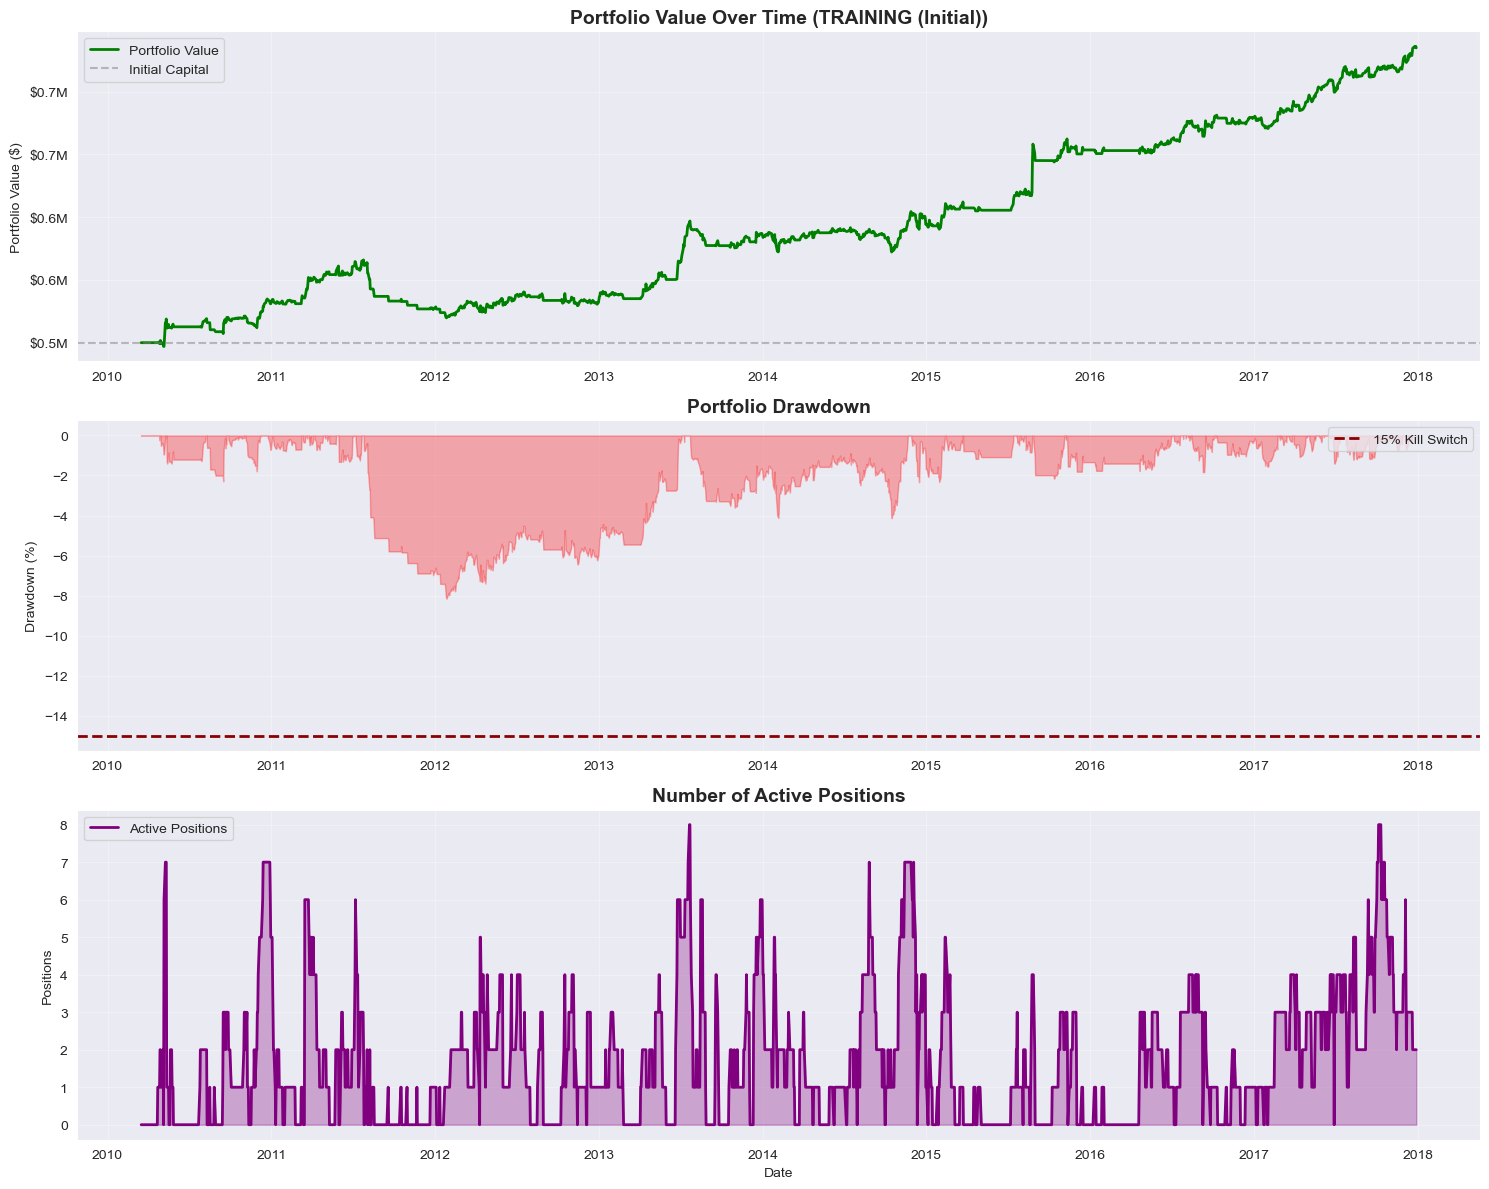


TRAINING (Initial) PERFORMANCE SUMMARY

Returns:
  Total Return..................      46.99%
  Annualized Return.............       5.07%
  Final Portfolio Value......... $   734,953

Risk Metrics:
  Annualized Volatility.........       4.51%
  Maximum Drawdown..............      -8.16%

Risk-Adjusted Returns:
  Sharpe Ratio..................       1.12
  Sortino Ratio.................       1.47
  Calmar Ratio..................       0.62

Trading Statistics:
  Total Trades..................        332
  Buy Signals...................        360
  Sell Signals..................        207
  Win Rate......................      47.29%
  Profit Factor.................       1.87
  Avg Win.......................       3.40%
  Avg Loss......................      -1.72%



🔍 STEP 2: Running grid search optimization...

GRID SEARCH OPTIMIZATION
Testing 20 parameter combinations...
Lookback window range: 10 to 30
RSI avg threshold range: 35.0 to 50.0



Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 157
Buy Signals: 94
Sell Signals: 63
Total Trades: 93
Final Portfolio Value: $569,905.08
Total Return: 13.98%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 157
Buy Signals: 94
Sell Signals: 63
Total Trades: 91
Final Portfolio Value: $576,791.76
Total Return: 15.36%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 147
Buy Signals: 84
Sell Signals: 63
Total Trades: 75
Final Portfolio Value: $572,932.86
Total Return: 14.59%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 119
Buy Signals: 56
Sell Signals: 63
Total Trades: 54
Final Portfolio Value: $551,565.54
Total Return: 10.31%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 343
Buy Signals: 203
Sell Signals: 140
Total Trades: 199
Final Portfolio Value: $638,337.73
Total Return: 27.67%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 349
Buy Signals: 209
Sell Signals: 140
Total Trades: 198
Final Portfolio Value: $618,142.35
Total Return: 23.63%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 303
Buy Signals: 163
Sell Signals: 140
Total Trades: 145
Final Portfolio Value: $616,515.44
Total Return: 23.30%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 251
Buy Signals: 111
Sell Signals: 140
Total Trades: 107
Final Portfolio Value: $605,118.86
Total Return: 21.02%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 558
Buy Signals: 351
Sell Signals: 207
Total Trades: 334
Final Portfolio Value: $755,018.72
Total Return: 51.00%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 567
Buy Signals: 360
Sell Signals: 207
Total Trades: 332
Final Portfolio Value: $734,952.99
Total Return: 46.99%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 502
Buy Signals: 295
Sell Signals: 207
Total Trades: 264
Final Portfolio Value: $657,818.38
Total Return: 31.56%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 415
Buy Signals: 208
Sell Signals: 207
Total Trades: 199
Final Portfolio Value: $620,061.81
Total Return: 24.01%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 726
Buy Signals: 459
Sell Signals: 267
Total Trades: 430
Final Portfolio Value: $796,549.62
Total Return: 59.31%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 748
Buy Signals: 481
Sell Signals: 267
Total Trades: 431
Final Portfolio Value: $783,561.84
Total Return: 56.71%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 671
Buy Signals: 404
Sell Signals: 267
Total Trades: 349
Final Portfolio Value: $745,672.49
Total Return: 49.13%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 581
Buy Signals: 314
Sell Signals: 267
Total Trades: 288
Final Portfolio Value: $688,880.15
Total Return: 37.78%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 854
Buy Signals: 523
Sell Signals: 331
Total Trades: 492
Final Portfolio Value: $836,454.92
Total Return: 67.29%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 888
Buy Signals: 557
Sell Signals: 331
Total Trades: 500
Final Portfolio Value: $822,581.07
Total Return: 64.52%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 817
Buy Signals: 486
Sell Signals: 331
Total Trades: 425
Final Portfolio Value: $774,361.24
Total Return: 54.87%


RSI RETRACEMENT BACKTEST - OPT
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing OPT:   0%|          | 0/1963 [00:00<?, ?it/s]


OPT COMPLETE
Total Events: 724
Buy Signals: 393
Sell Signals: 331
Total Trades: 358
Final Portfolio Value: $746,436.73
Total Return: 49.29%


OPTIMIZATION RESULTS
Best Sharpe Ratio: 1.264
Optimal Lookback Window: 30 days
Optimal RSI Avg Threshold: 35.00
Total Return: 67.29%
Win Rate: 46.34%
Total Trades: 492


📈 STEP 3: Visualizing 3D optimization surface...


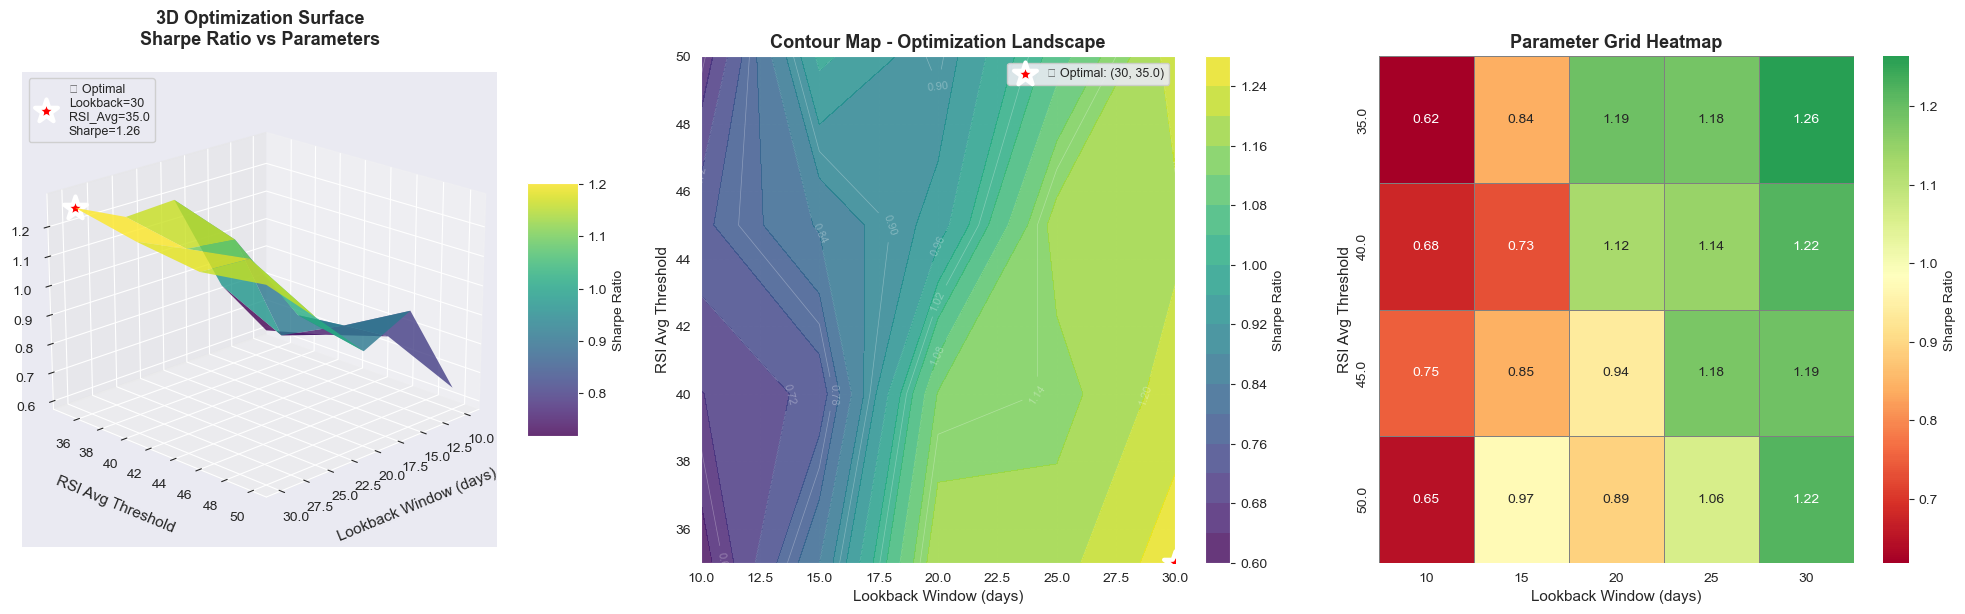

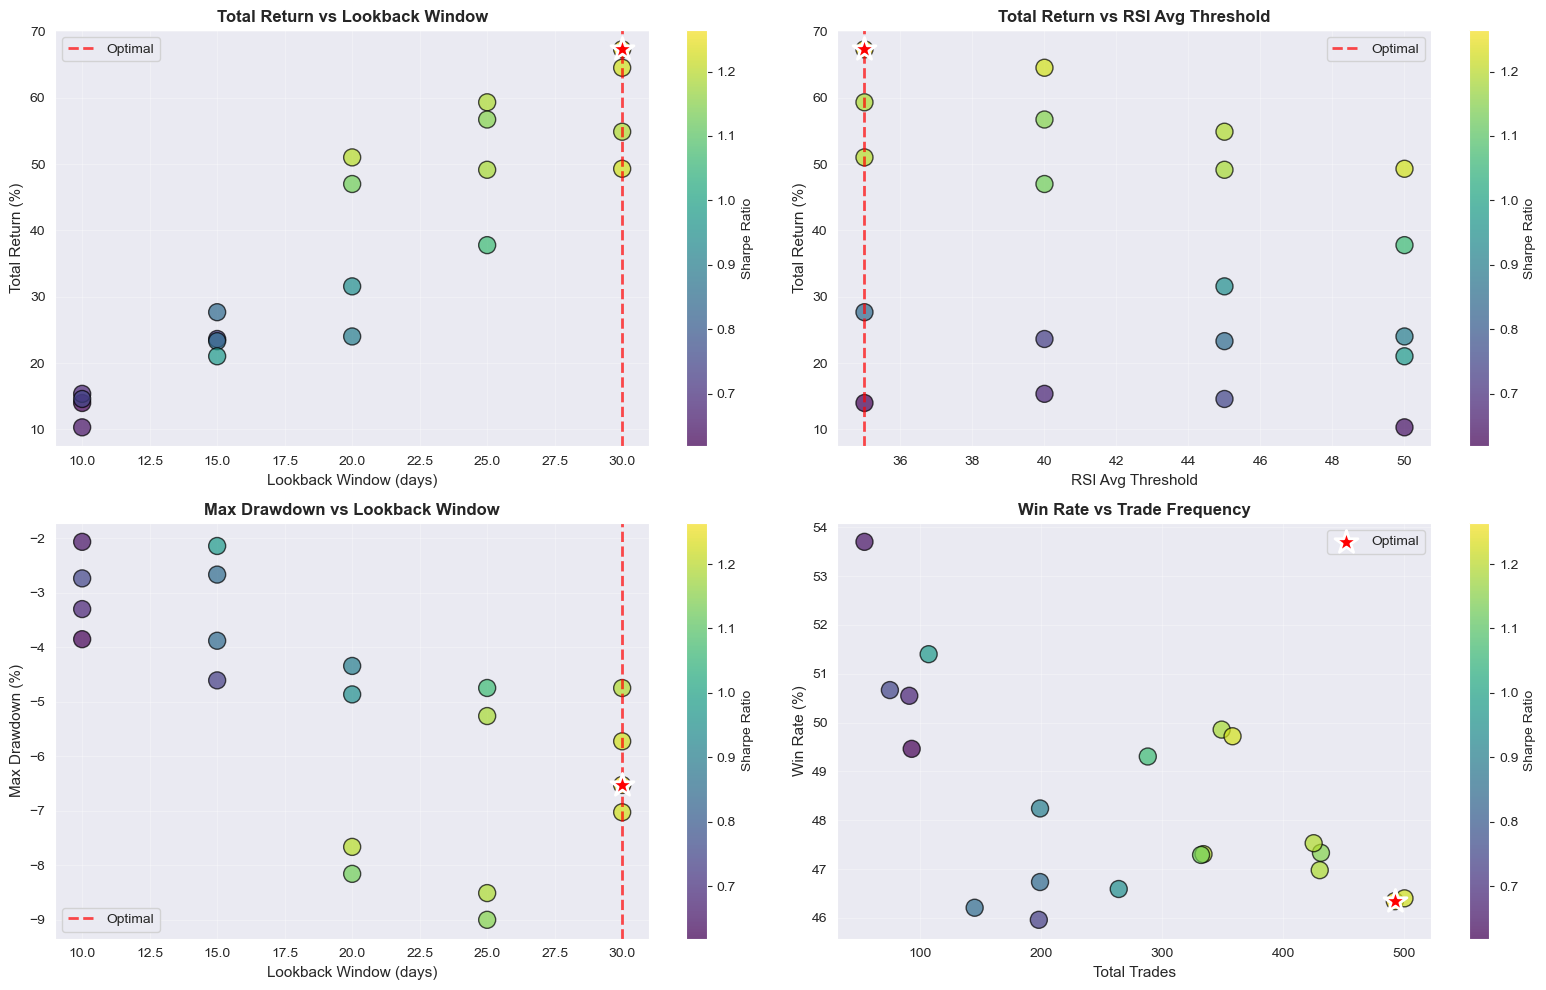


🎯 STEP 4: Re-training with optimal parameters...

DOWNLOADING DATA
Period: 2010-01-01 to 2017-12-31
Stocks: 30 symbols


Downloading:   0%|          | 0/30 [00:00<?, ?it/s]

$BRK.B: possibly delisted; no timezone found



✅ Successfully loaded 29 stocks


RSI RETRACEMENT BACKTEST - TRAINING (Optimal)
Period: 2010-03-17 to 2017-12-29
Universe: 29 stocks
Initial Capital: $500,000



Processing TRAINING (Optimal):   0%|          | 0/1963 [00:00<?, ?it/s]


TRAINING (Optimal) COMPLETE
Total Events: 854
Buy Signals: 523
Sell Signals: 331
Total Trades: 492
Final Portfolio Value: $836,454.92
Total Return: 67.29%



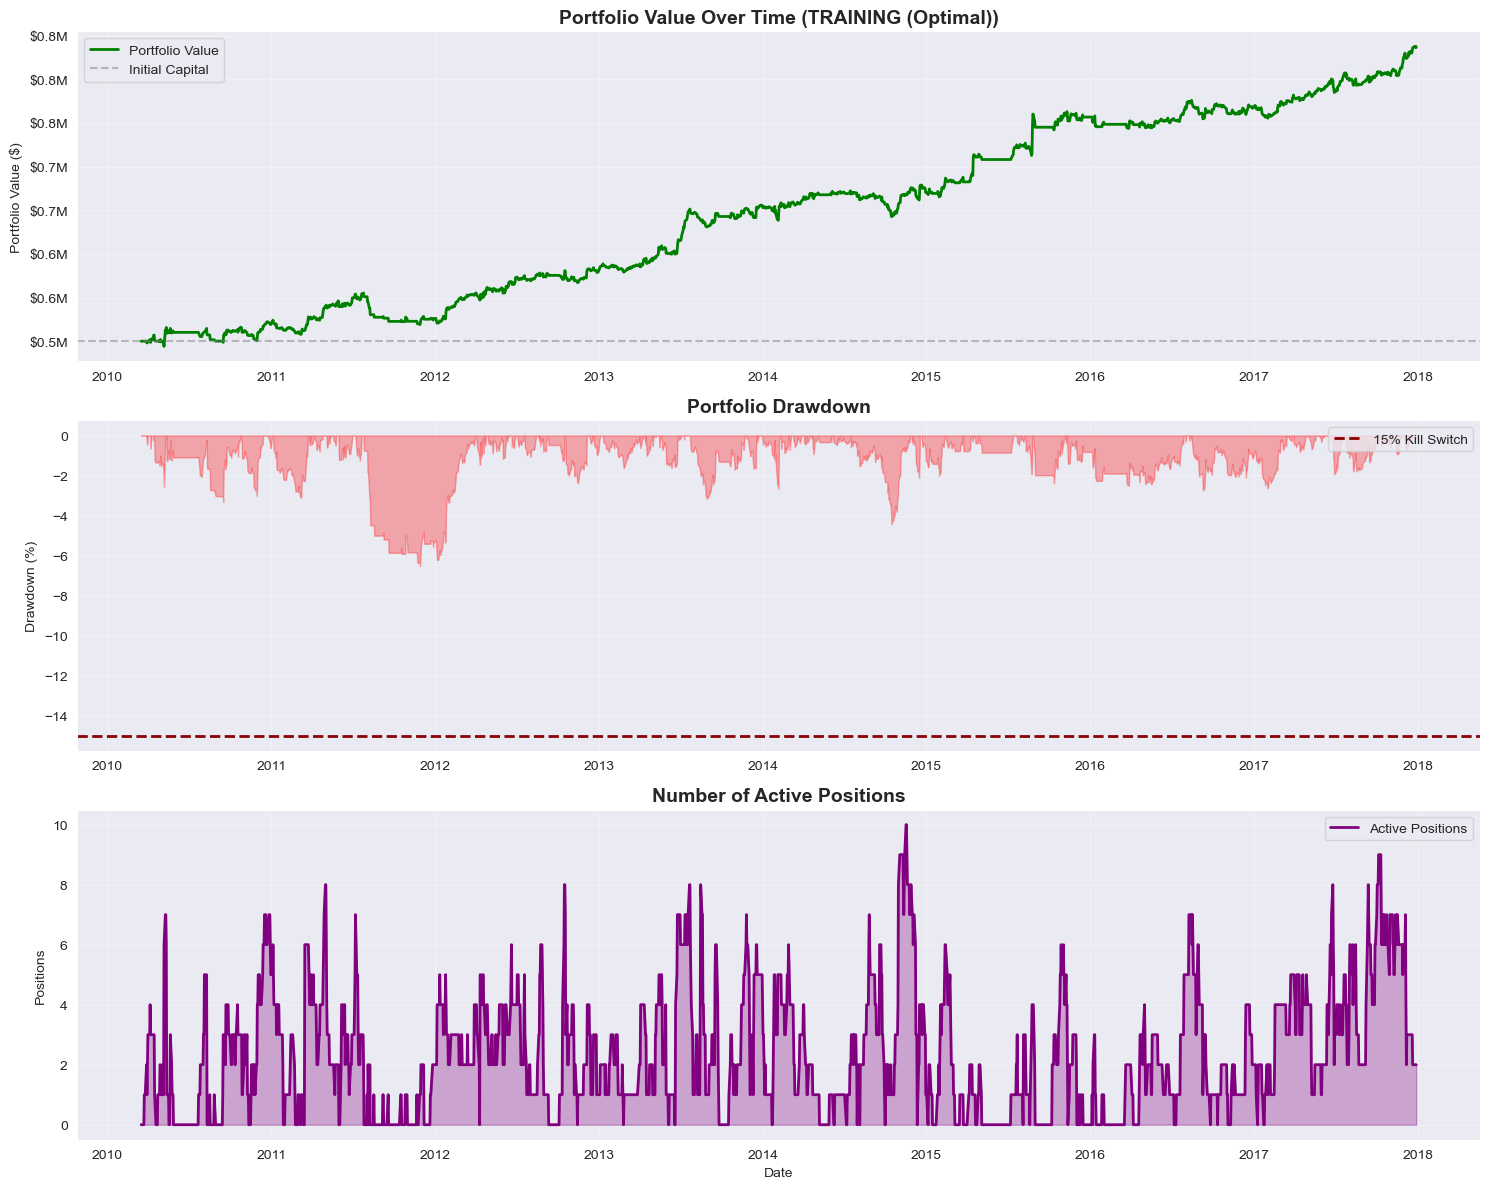


TRAINING (Optimal) PERFORMANCE SUMMARY

Returns:
  Total Return..................      67.29%
  Annualized Return.............       6.83%
  Final Portfolio Value......... $   836,455

Risk Metrics:
  Annualized Volatility.........       5.40%
  Maximum Drawdown..............      -6.53%

Risk-Adjusted Returns:
  Sharpe Ratio..................       1.26
  Sortino Ratio.................       1.78
  Calmar Ratio..................       1.05

Trading Statistics:
  Total Trades..................        492
  Buy Signals...................        523
  Sell Signals..................        331
  Win Rate......................      46.34%
  Profit Factor.................       1.83
  Avg Win.......................       3.60%
  Avg Loss......................      -1.75%



🧪 STEP 5: Running out-of-sample test...

DOWNLOADING DATA
Period: 2018-01-01 to 2019-12-31
Stocks: 30 symbols


Downloading:   0%|          | 0/30 [00:00<?, ?it/s]

$BRK.B: possibly delisted; no timezone found



✅ Successfully loaded 29 stocks


RSI RETRACEMENT BACKTEST - TEST (Out-of-Sample)
Period: 2018-03-15 to 2019-12-30
Universe: 29 stocks
Initial Capital: $500,000



Processing TEST (Out-of-Sample):   0%|          | 0/452 [00:00<?, ?it/s]


TEST (Out-of-Sample) COMPLETE
Total Events: 196
Buy Signals: 105
Sell Signals: 91
Total Trades: 99
Final Portfolio Value: $470,274.33
Total Return: -5.95%



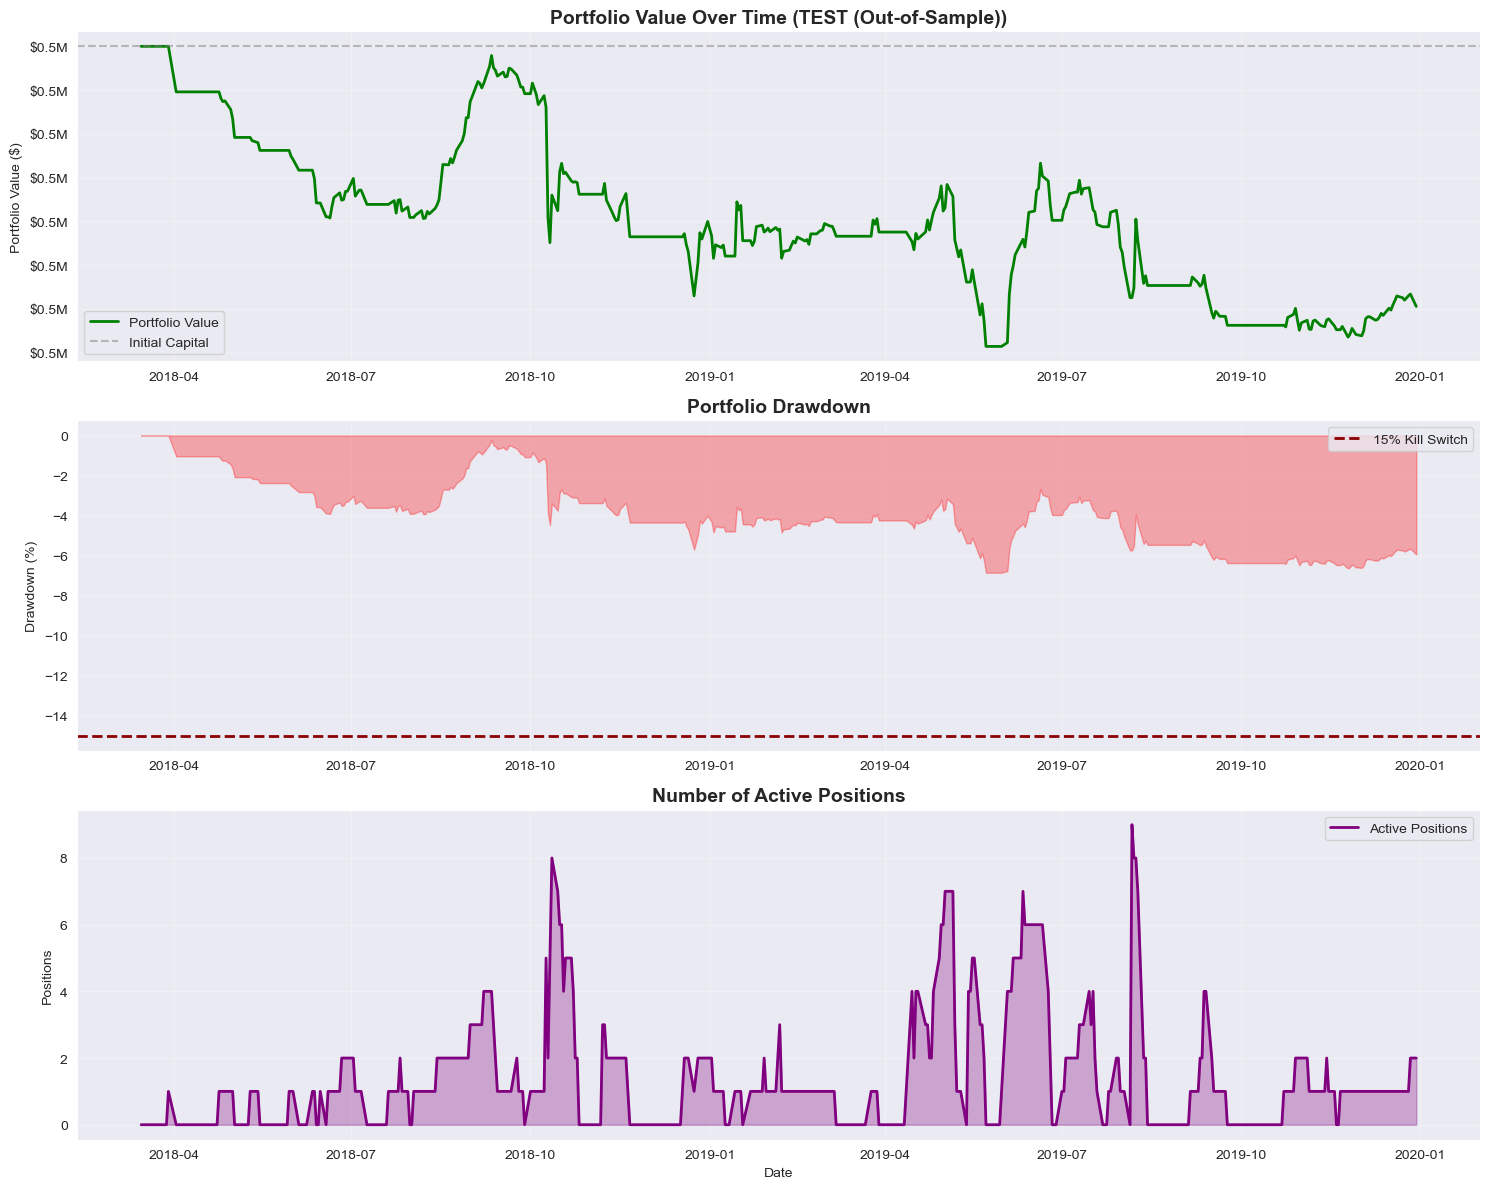


TEST (Out-of-Sample) PERFORMANCE SUMMARY

Returns:
  Total Return..................      -5.95%
  Annualized Return.............      -3.36%
  Final Portfolio Value......... $   470,274

Risk Metrics:
  Annualized Volatility.........       4.59%
  Maximum Drawdown..............      -6.86%

Risk-Adjusted Returns:
  Sharpe Ratio..................      -0.73
  Sortino Ratio.................      -0.71
  Calmar Ratio..................      -0.49

Trading Statistics:
  Total Trades..................         99
  Buy Signals...................        105
  Sell Signals..................         91
  Win Rate......................      36.36%
  Profit Factor.................       0.65
  Avg Win.......................       2.54%
  Avg Loss......................      -1.97%



📊 STEP 6: Comparing in-sample vs out-of-sample performance...


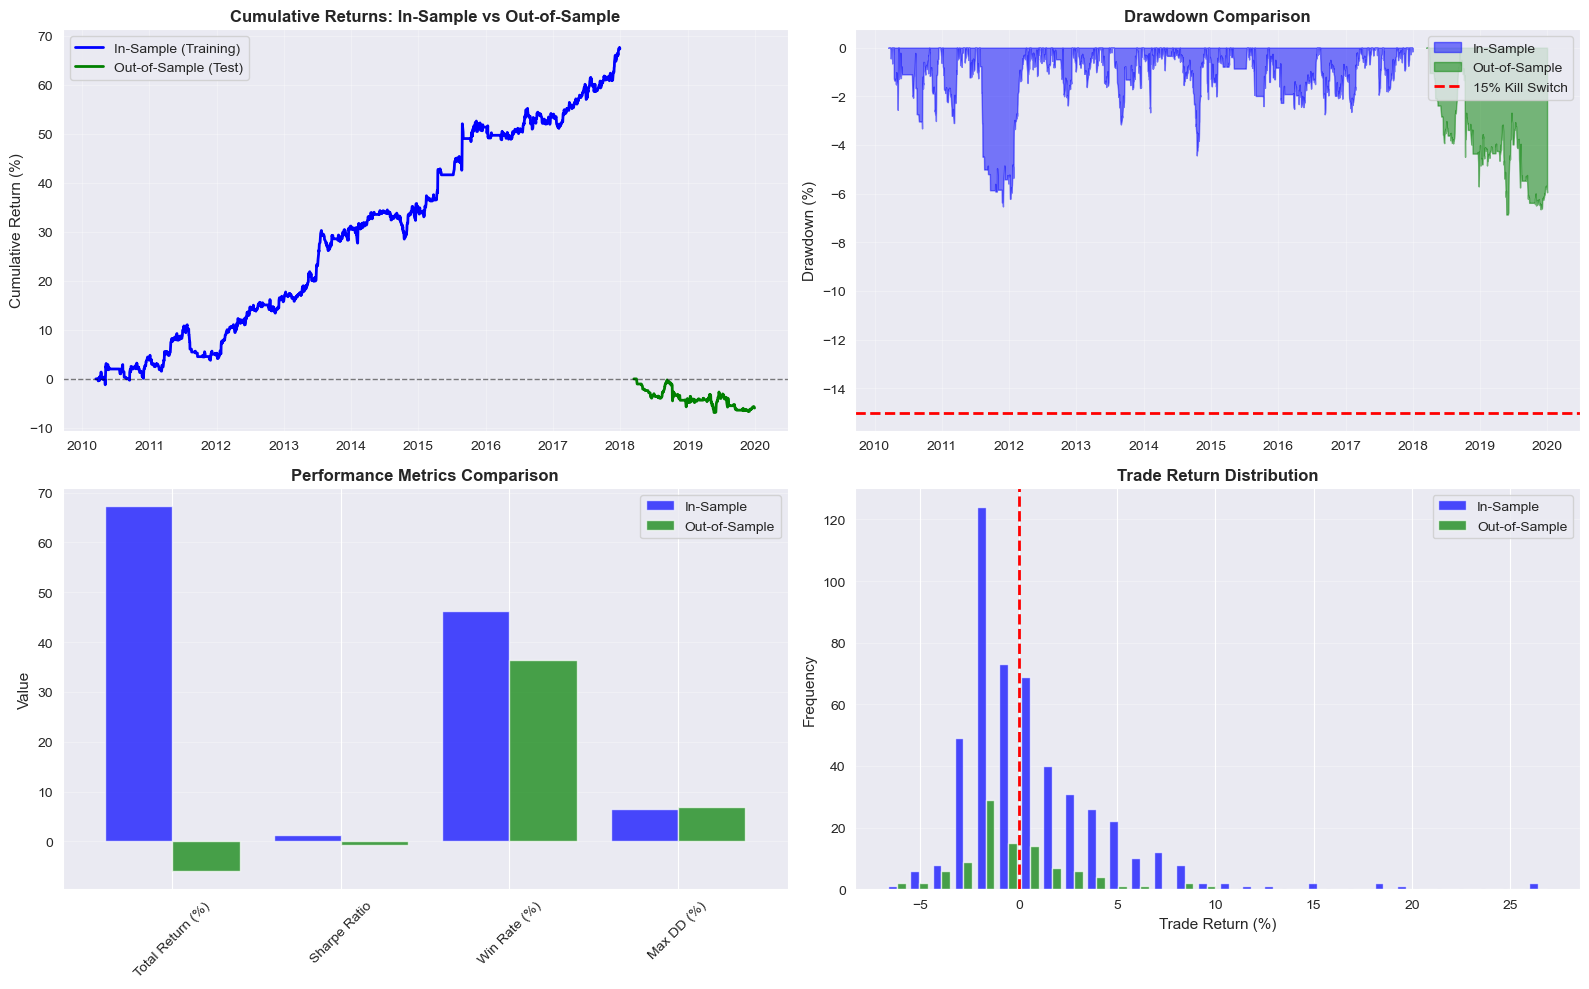


IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON
Metric                                    In-Sample   Out-of-Sample Difference
---------------------------------------------------------------------------
Total Return (%)                              67.29           -5.95     -73.24
Annualized Return (%)                          6.83           -3.36     -10.19
Sharpe Ratio                                   1.26           -0.73      -2.00
Max Drawdown (%)                              -6.53           -6.86      -0.33
Win Rate (%)                                  46.34           36.36      -9.98
Total Trades                                    492              99       -393

Optimal Parameters (from in-sample optimization):
  Lookback Window: 30
  RSI Avg Threshold: 35.0


✅ RSI RETRACEMENT STRATEGY COMPLETE!

Key Results:
  Optimal Lookback Window: 30 days
  Optimal RSI Avg Threshold: 35.00

In-Sample Performance:
  Sharpe Ratio: 1.264
  Total Return: 67.29%
  Win Rate: 46.34%
  Total Trades: 492

O

In [13]:
# ============================================================================
# FINAL NOTEBOOK CELL - RSI RETRACEMENT STRATEGY WITH GRID SEARCH
# ============================================================================

# Configuration
train_start = "2010-01-01"
train_end = "2017-12-31"
test_start = "2018-01-01"
test_end = "2019-12-31"
stock_list = SPY_STOCKS[:30]  # Use top 30 stocks

# Strategy parameters
strategy_params = {
    'initial_capital': 500000.0,
    'transaction_cost': 0.0,
    'leverage': 0.0,
    'max_positions': 10,
    'max_position_size': 0.2,
    'stop_loss_pct': 0.02,
    'trailing_stop_pct': 0.015,
    'risk_per_trade': 0.02,
    # RSI retracement parameters
    'rsi_high_threshold': 70.0,
    'rsi_low_threshold': 30.0,
    'rsi_retrace_upper': 40.0,
    'rsi_retrace_lower': 30.0,
    'rsi_retrace_short_upper': 70.0,
    'rsi_retrace_short_lower': 60.0,
    'lookback_window': 20,
    'rsi_avg_window': 5,
    'rsi_avg_threshold_buy': 40.0,
    'rsi_avg_threshold_sell': 60.0
}

print("\n" + "="*70)
print("RSI RETRACEMENT STRATEGY - COMPLETE WORKFLOW")
print("="*70)
print("\nWorkflow Steps:")
print("  1. Download and prepare data")
print("  2. Run grid search optimization (training period)")
print("  3. Visualize 3D optimization surface")
print("  4. Train with optimal parameters")
print("  5. Test out-of-sample")
print("  6. Compare results")
print("\n" + "="*70)

# STEP 1: Download training data
print("\n📊 STEP 1: Downloading training data...")
train_results = run_backtest(
    start_date=train_start,
    end_date=train_end,
    stock_list=stock_list,
    period_name="TRAINING (Initial)",
    **strategy_params
)

# STEP 2: Run grid search optimization
print("\n🔍 STEP 2: Running grid search optimization...")
optimization_results = optimize_parameters_grid_search(
    stock_data=train_results['raw_stock_data'],  # Use raw data for recalculation
    config=train_results['config'],
    lookback_range=(10, 30, 5),  # Test lookback from 10 to 30 days (5 points)
    rsi_avg_threshold_range=(35, 50, 4)  # Test RSI avg threshold from 35 to 50 (4 points)
)

# STEP 3: Visualize 3D optimization surface
print("\n📈 STEP 3: Visualizing 3D optimization surface...")
plot_3d_optimization_surface(optimization_results)

# STEP 4: Re-train with optimal parameters
print("\n🎯 STEP 4: Re-training with optimal parameters...")
optimal_lookback = int(optimization_results['best_params']['lookback_window'])
optimal_rsi_avg = optimization_results['best_params']['rsi_avg_threshold']

optimal_train_params = strategy_params.copy()
optimal_train_params['lookback_window'] = optimal_lookback
optimal_train_params['rsi_avg_threshold_buy'] = optimal_rsi_avg

train_optimal_results = run_backtest(
    start_date=train_start,
    end_date=train_end,
    stock_list=stock_list,
    period_name="TRAINING (Optimal)",
    **optimal_train_params
)

# STEP 5: Out-of-sample test
print("\n🧪 STEP 5: Running out-of-sample test...")
test_results = run_backtest(
    start_date=test_start,
    end_date=test_end,
    stock_list=stock_list,
    period_name="TEST (Out-of-Sample)",
    **optimal_train_params
)

# STEP 6: Compare in-sample vs out-of-sample
print("\n📊 STEP 6: Comparing in-sample vs out-of-sample performance...")
compare_in_sample_out_sample(
    train_metrics=train_optimal_results['metrics'],
    test_metrics=test_results['metrics'],
    optimal_params={
        'lookback_window': optimal_lookback,
        'rsi_avg_threshold': optimal_rsi_avg
    }
)

# Final Summary
print("\n" + "="*70)
print("✅ RSI RETRACEMENT STRATEGY COMPLETE!")
print("="*70)
print("\nKey Results:")
print(f"  Optimal Lookback Window: {optimal_lookback} days")
print(f"  Optimal RSI Avg Threshold: {optimal_rsi_avg:.2f}")
print(f"\nIn-Sample Performance:")
print(f"  Sharpe Ratio: {train_optimal_results['metrics']['sharpe_ratio']:.3f}")
print(f"  Total Return: {train_optimal_results['metrics']['total_return']*100:.2f}%")
print(f"  Win Rate: {train_optimal_results['metrics']['win_rate']*100:.2f}%")
print(f"  Total Trades: {train_optimal_results['metrics']['total_trades']}")
print(f"\nOut-of-Sample Performance:")
print(f"  Sharpe Ratio: {test_results['metrics']['sharpe_ratio']:.3f}")
print(f"  Total Return: {test_results['metrics']['total_return']*100:.2f}%")
print(f"  Win Rate: {test_results['metrics']['win_rate']*100:.2f}%")
print(f"  Total Trades: {test_results['metrics']['total_trades']}")
print("\n" + "="*70)

# Store results for further analysis
results = {
    'optimization': optimization_results,
    'train': train_optimal_results,
    'test': test_results,
    'optimal_params': {
        'lookback_window': optimal_lookback,
        'rsi_avg_threshold': optimal_rsi_avg
    }
}

print("\n💾 Results stored in 'results' dictionary")
print("\nAccess components:")
print("  - results['optimization']  # Grid search data and 3D surface")
print("  - results['train']         # Training backtest results")
print("  - results['test']          # Test backtest results")
print("  - results['optimal_params']# Optimal parameter values")
print("\n" + "="*70)